# Import Libraries

In [12]:
import torch
print(torch.__version__)
import torchvision
import torch.nn as nn

import os
import sys
import time

import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib inline

2.6.0


# GPU/CUDA setup

In [13]:
# if torch.cuda.is_available():
#     print("CUDA enabled!")
# device = 'cuda:0'
# os.environ['CUDA_VISIBLE_DEVICES'] = ','.join(f'{i}' for i in range(1))

In [14]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Autoencoder Helpers

In [16]:
"""
Adopted from @author Oscar Li

Source: https://github.com/OscarcarLi/PrototypeDL
"""
def makedirs(path):
    '''
    if path does not exist in the file system, create it
    '''
    if not os.path.exists(path):
        os.makedirs(path)

def list_of_distances(X, Y):
    '''
    Given a list of vectors, X = [x_1, ..., x_n], and another list of vectors,
    Y = [y_1, ... , y_m], we return a list of vectors
            [[d(x_1, y_1), d(x_1, y_2), ... , d(x_1, y_m)],
             ...
             [d(x_n, y_1), d(x_n, y_2), ... , d(x_n, y_m)]],
    where the distance metric used is the sqared euclidean distance.
    The computation is achieved through a clever use of broadcasting.
    '''
    XX = torch.reshape(list_of_norms(X), shape=(-1, 1))

    YY = torch.reshape(list_of_norms(Y), shape=(1, -1))
    output = XX + YY - 2 * torch.matmul(X, torch.transpose(Y, 0, 1))
    return output

def list_of_norms(X):
    '''
    X is a list of vectors X = [x_1, ..., x_n], we return
        [d(x_1, x_1), d(x_2, x_2), ... , d(x_n, x_n)], where the distance
    function is the squared euclidean distance.
    '''
    return torch.sum(torch.pow(X, 2),dim=1)

def print_and_write(str, file):
    '''
    print str to the console and also write it to file
    '''
    print(str)
    file.write(str + '\n')



# Network Modules

In [17]:
class EncoderLayer(nn.Module):
    def __init__(self, in_channels=1, n_maps=32, out_channels=10, n_layers=4):
        super(EncoderLayer, self).__init__()
        
        el = []
        el += [ConvLayer(in_channels, n_maps, stride=2, padding=1)]
        for i in range(0, n_layers-2):
            el += [ConvLayer(n_maps, n_maps, stride=2, padding=1)]   
        el += [ConvLayer(n_maps, out_channels, stride=2, padding=1)]

        self.encoder = nn.Sequential(*el)

    def forward(self, x):
        return self.encoder(x)

class DecoderLayer(nn.Module):
    def __init__(self, in_channels=10, n_maps=32, out_channels=1, out_shapes=[], n_layers=4):
        super(DecoderLayer, self).__init__()

        dl = []
        dl += [DeConvLayer(in_channels, n_maps, out_shape=out_shapes[-1], stride=2, padding=1, output_padding=1)]
        for i in range(1, n_layers-1):
            dl += [DeConvLayer(n_maps, n_maps, out_shape=out_shapes[-(i+1)], stride=2, padding=1, output_padding=1)]
        dl += [DeConvLayer(n_maps, out_channels, out_shape=out_shapes[-n_layers], stride=2, padding=1, 
                           output_padding=1, activation=nn.Sigmoid)]

        self.decoder = nn.Sequential(*dl)

    def forward(self, x):
        return self.decoder(x)

class PrototypeLayer(nn.Module):
    def __init__(self, in_channels=10, n_prototypes=15):
        super(PrototypeLayer, self).__init__()

        self.prototype_distances = torch.rand(n_prototypes, in_channels, requires_grad=True).to(device)

    def forward(self, x):
        return list_of_distances(x, self.prototype_distances)

class ConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, stride=2, padding=1, activation=nn.ReLU):
        super(ConvLayer, self).__init__()
        
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3,
                             stride=stride, padding=padding)
        self.activation = activation()

    def forward(self, x):
        self.in_dim = x.shape[-2:]
        return self.activation(self.conv(x)) 

class DeConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, out_shape, stride=2, padding=1, output_padding=1, activation=nn.ReLU):
        super(DeConvLayer, self).__init__()
        self.out_shape = out_shape
        self.dconv = nn.ConvTranspose2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, 
                                        stride=stride, padding=padding, output_padding=output_padding)
        self.activation = activation()

    def forward(self, x):
        out_convt = self.dconv(x)
        if (out_convt.shape[-2:][0] != self.out_shape[0]) & (out_convt.shape[-2:][1] != self.out_shape[1]):
            out_convt = out_convt[:,:,(out_convt.shape[-2:][0] - self.out_shape[0]):,
                                 (out_convt.shape[-2:][1] - self.out_shape[1]):]
        return self.activation(out_convt)

class FullyConnectedLayer(nn.Module):
    def __init__(self, in_features=15, out_features=10):
        super(FullyConnectedLayer, self).__init__()

        self.linear = nn.Linear(in_features=in_features, out_features=out_features)

    def forward(self, x):
        return self.linear(x)

class Softmax(nn.Module):
    def __init__(self):
        super(Softmax, self).__init__()

        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        return self.softmax(x)

# CAE Model definition

In [18]:
class CAEModel(nn.Module):
    def __init__(self, input_shape=(1, 1, 28,28), n_maps=32, n_prototypes=15, n_layers=4, n_classes=10):
        super(CAEModel, self).__init__()

        # add encoder layer
        self.encoder = EncoderLayer(in_channels=input_shape[1], n_maps=n_maps, out_channels=n_classes, n_layers=n_layers)
        
        # add prototype layer
        self.in_channels_prototype = self.encoder.forward(torch.randn(input_shape)).view(-1,1).shape[0]
        self.prototype_layer = PrototypeLayer(in_channels=self.in_channels_prototype, n_prototypes=n_prototypes)

        # add decoder layer
        decoder_out_shapes = []
        for layer in self.encoder.modules():
            if isinstance(layer, ConvLayer):
                decoder_out_shapes += [list(layer.in_dim)]
        self.decoder = DecoderLayer(in_channels=n_classes, n_maps=n_maps, out_channels=input_shape[1], out_shapes=decoder_out_shapes)
        
        # output layer
        # add final fully connected layer
        self.fc = FullyConnectedLayer(in_features=n_prototypes, out_features=n_classes)
        self.feature_vectors = None

    def forward(self, x):
        encoder_out = self.encoder(x)
        self.feature_vectors = encoder_out
        prototype_out = self.prototype_layer(encoder_out.view(-1,self.in_channels_prototype))
        fc_out = self.fc(prototype_out)
        return fc_out

# Data Processing

In [20]:
"""
Adopted from @author Oscar Li

Source: https://github.com/OscarcarLi/PrototypeDL
"""
import numpy as np
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def batch_elastic_transform(images, sigma, alpha, height, width, random_state=None):
    '''
    this code is borrowed from chsasank on GitHubGist
    Elastic deformation of images as described in [Simard 2003].
    
    images: a two-dimensional numpy array; we can think of it as a list of flattened images
    sigma: the real-valued variance of the gaussian kernel
    alpha: a real-value that is multiplied onto the displacement fields
    
    returns: an elastically distorted image of the same shape
    '''
    assert len(images.shape) == 2
    # the two lines below ensure we do not alter the array images
    e_images = np.empty_like(images)
    e_images[:] = images
    
    e_images = e_images.reshape(-1, height, width)
    
    if random_state is None:
        random_state = np.random.RandomState(None)
    x, y = np.mgrid[0:height, 0:width]
    
    for i in range(e_images.shape[0]):
        
        dx = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        dy = gaussian_filter((random_state.rand(height, width) * 2 - 1), sigma, mode='constant') * alpha
        indices = x + dx, y + dy
        e_images[i] = map_coordinates(e_images[i], indices, order=1)

    return e_images.reshape(-1, height*width)

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_972/1429368971.py:7: DeprecationWarning: Please import `map_coordinates` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import map_coordinates
/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_972/1429368971.py:8: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import gaussian_filter


# MINIST Data Loader

In [21]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler

# function to load and return train and val multi-process iterator over the MNIST dataset.

def get_train_val_loader(data_dir, batch_size, random_seed, augment=False, val_size=0.2, 
                         shuffle=True, show_sample=False, num_workers=0, pin_memory=True):

    # load the dataset
    train_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=transforms.ToTensor())
    val_dataset = datasets.MNIST(root=data_dir, train=True, 
                download=True, transform=transforms.ToTensor())

    num_train = len(train_dataset)
    indices = list(range(num_train))
    split = int(np.floor(val_size * num_train))

    if shuffle == True:
        np.random.seed(random_seed)
        np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)

    # create data iterator
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, 
                                               num_workers=num_workers, pin_memory=pin_memory)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, sampler=val_sampler, 
                                             num_workers=num_workers, pin_memory=pin_memory)
    return (train_loader, val_loader)

# function to load and return a multi-process test iterator over the MNIST dataset.
def get_test_loader(data_dir, 
                    batch_size,
                    shuffle=True,
                    num_workers=0,
                    pin_memory=True):

    dataset = datasets.MNIST(root=data_dir, train=False, download=True, transform=transforms.ToTensor())
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, 
                                              num_workers=num_workers, pin_memory=pin_memory)
    return data_loader

# The directory to save the model

In [22]:
model_folder = os.path.join(os.getcwd(), "saved_model", "mnist_model", "mnist_cae_1")
makedirs(model_folder)
img_folder = os.path.join(model_folder, "img")
makedirs(img_folder)
model_filename = "mnist_cae"

# console_log is the handle to a text file that records the console output
log_folder=os.path.join(model_folder, "log")
makedirs(log_folder)
console_log = open(os.path.join(log_folder, "console_log.txt"), "w+")

# Model parameters

In [23]:
# training parameters
learning_rate = 0.002
training_epochs = 100 #1500
batch_size = 250              # the size of a minibatch
test_display_step = 100       # how many epochs we do evaluate on the test set once
save_step = 5                # how frequently do we save the model to disk

# elastic deformation parameters
sigma = 4
alpha =20

# lambda's are the ratios between the four error terms
lambda_class = 20
lambda_ae = 1
lambda_1 = 1            # 1 and 2 here corresponds to the notation we used in the paper
lambda_2 = 1

# input data parameters
input_height = 28         # MNIST data input shape
input_width = input_height
n_input_channel = 1       # the number of color channels; for MNIST is 1.
input_size = input_height * input_width * n_input_channel   # the number of pixels in one input image
input_shape = (1, n_input_channel, input_height, input_height) # input shape to pass in the model
n_classes = 10

# Network Parameters
n_prototypes = 15         # the number of prototypes
n_layers = 4
n_maps = 32

# Load MNIST Data

In [24]:
#you may need to install the following packages in your python environment if it fails to donload data.
#conda install -c conda-forge ipywidgets
#jupyter nbextension enable --py widgetsnbextension
# the following two for jupyter hosted environment
#conda install -n base -c conda-forge widgetsnbextension
#conda install -n <your_environment_name> -c conda-forge ipywidgets


In [25]:
# data load and split parameters
random_seed = 1
n_workers = 0
data_folder = 'data'

# download MNIST data
train_loader, val_loader = get_train_val_loader(data_folder, batch_size, random_seed, augment=False, val_size=0.2,
                           shuffle=True, show_sample=False, num_workers=0, pin_memory=True)
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Get the CAE model

In [26]:
model = CAEModel(input_shape=input_shape, n_maps=n_maps, n_prototypes=n_prototypes, 
                 n_layers=n_layers, n_classes=n_classes).to(device)

# Optimizer setup

In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model on MNIST data

In [ ]:
from tqdm import tqdm, tqdm_notebook

start_time= time.time()

# train the model
for epoch in range(0, training_epochs):
    print_and_write("#"*80, console_log)
    print_and_write("Epoch: %04d" % (epoch+1)+"/%04d" % (training_epochs), console_log)
    n_train_batch = len(train_loader)
    n_val_batch = len(val_loader)
    n_test_batch = len(test_loader)
    start = time.time()

    train_ce, train_ae, train_e1, train_e2, train_te, train_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    with tqdm(total=len(train_loader), file=sys.stdout) as pbar:
        for i, batch in enumerate(train_loader):
            batch_x = batch[0]
            batch_y = batch[1]

            # store original batch shape to put it back into this shape after transformation
            batch_shape = batch_x.shape

            # apply elastic transform
            elastic_batch_x = batch_elastic_transform(batch_x.view(batch_size, -1), sigma=sigma, alpha=alpha, height=input_height, width=input_width)
            elastic_batch_x = torch.reshape(torch.tensor(elastic_batch_x), batch_shape)
            elastic_batch_x = elastic_batch_x.to(device)

            batch_y = batch_y.to(device)

            optimizer.zero_grad()        

            pred_y = model.forward(elastic_batch_x)

            # softmax crossentropy loss
            loss_function = torch.nn.CrossEntropyLoss()
            train_ce = loss_function(pred_y, batch_y)

            prototype_distances = model.prototype_layer.prototype_distances
            feature_vectors = model.feature_vectors

            train_e1 = torch.mean(torch.min(list_of_distances(prototype_distances, feature_vectors.view(-1, model.in_channels_prototype)), dim=1)[0])
            train_e2 = torch.mean(torch.min(list_of_distances(feature_vectors.view(-1, model.in_channels_prototype ), prototype_distances), dim=1)[0])

            out_decoder = model.decoder(feature_vectors)
            train_ae = torch.mean(list_of_norms(out_decoder-elastic_batch_x))

            train_te = lambda_class * train_ce +\
                    lambda_1 * train_e1 +\
                    lambda_2 * train_e2 +\
                    lambda_ae * train_ae

            train_te.backward()

            optimizer.step()

            # train accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            train_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

            pbar.set_description('batch: %03d' % (1 + i))
            pbar.update(1)
    
    train_ac /= n_train_batch
    print_and_write("training set errors:"+"\tclassification error: {:.6f}".format(train_ce)+
                    "\tautoencoder error: {:.6f}".format(train_ae)+
                    "\terror_1: {:.6f}".format(train_e1)+
                    "\terror_2: {:.6f}".format(train_e2)+
                    "\ttotal error: {:.6f}".format(train_te)+
                    "\taccuracy: {:.6f}".format(train_ac), console_log)
    print_and_write('training takes {0:.2f} seconds.'.format((time.time() - start)), console_log)
     
    # validation set error terms evaluation
    val_ce, val_ae, val_e1, val_e2, val_te, val_ac = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    
    with tqdm(total=len(val_loader), file=sys.stdout) as pbar:
        for i, batch in enumerate(val_loader):
            batch_x = batch[0]
            batch_y = batch[1]
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            pred_y = model.forward(batch_x)

            loss_function = torch.nn.CrossEntropyLoss()
            val_ce = loss_function(pred_y, batch_y)

            prototype_distances = model.prototype_layer.prototype_distances
            feature_vectors = model.feature_vectors

            val_e1 = torch.mean(torch.min(list_of_distances(prototype_distances, feature_vectors.view(-1, model.in_channels_prototype)), dim=1)[0])
            val_e2 = torch.mean(torch.min(list_of_distances(feature_vectors.view(-1, model.in_channels_prototype ), prototype_distances), dim=1)[0])

            out_decoder = model.decoder(feature_vectors)
            val_ae = torch.mean(list_of_norms(out_decoder-batch_x))

            val_te = lambda_class * val_ce +\
                    lambda_1 * val_e1 +\
                    lambda_2 * val_e2 +\
                    lambda_ae * val_ae
            # validation accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            val_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

            pbar.set_description('batch: %03d' % (1 + i))
            pbar.update(1)
           
    val_ac /= n_val_batch
    # after every epoch, check the error terms on the entire training set
    print_and_write("validation set errors:"+"\tclassification error: {:.6f}".format(val_ce)+
                    "\tautoencoder error: {:.6f}".format(val_ae)+
                    "\terror_1: {:.6f}".format(val_e1)+
                    "\terror_2: {:.6f}".format(val_e2)+
                    "\ttotal error: {:.6f}".format(val_te)+
                    "\taccuracy: {:.6f}".format(val_ac), console_log)
    
    # test set accuracy evaluation
    if (epoch+1) % test_display_step == 0 or epoch == training_epochs - 1:
        test_ac = 0

        for i, batch in enumerate(test_loader):
            batch_x = batch[0]
            batch_y = batch[1]
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)

            pred_y = model.forward(batch_x)

            # test accuracy
            max_vals, max_indices = torch.max(pred_y,1)
            n = max_indices.size(0)
            test_ac += (max_indices == batch_y).sum(dtype=torch.float32)/n

        test_ac /= n_test_batch

        print_and_write("test set:", console_log)
        print_and_write("\taccuracy: {:.4f}".format(test_ac), console_log)

    if (epoch+1) % save_step == 0 or epoch == training_epochs - 1:
        # save model states
        model_state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict(), 'epoch': epoch+1}
        torch.save(model_state, os.path.join(model_folder, model_filename+'%05d.pth' % (epoch+1)))

        # save outputs as images
        # decode prototype vectors
        prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()

        # visualize the prototype images
        print_and_write("Visualizing the prototype images:", console_log)
        n_cols = 5
        n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
        g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
        for i in range(n_rows):
            for j in range(n_cols):
                if i*n_cols + j < n_prototypes:
                    b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                    cmap='gray',
                                    interpolation='none')
                    b[i][j].axis('off')
                    
        plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
                    transparent=True, bbox_inches='tight', pad_inches=0)
        plt.show()

        plt.close()

        # apply encoding and decoding over a small subset of the training set
        print_and_write("Visualizing encoded and decoded images:", console_log)
        batch_x = []
        for batch in train_loader:
            batch_x = batch[0].to(device)
            break

        examples_to_show = 10
        
        encoded = model.encoder.forward(batch_x[:examples_to_show])
        decoded = model.decoder.forward(encoded)

        decoded = decoded.detach().cpu()
        imgs = batch_x.detach().cpu()

        # compare original images to their reconstructions
        f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
        for i in range(examples_to_show):
            a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
            a[0][i].axis('off')
            a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
            a[1][i].axis('off')
            
        plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
                    transparent=True,
                    bbox_inches='tight',
                    pad_inches=0)
        plt.show()
        plt.close()
        
print_and_write('Total taken time {0:.2f} seconds.'.format((time.time() - start_time)), console_log)
print_and_write("Optimization Finished!", console_log)
console_log.close()

################################################################################
Epoch: 0001/0100
batch: 001:   1%|          | 1/192 [00:00<00:42,  4.46it/s]

/var/folders/px/2nlbn4cs2bbdd7cgvvptqfqc0000gn/T/ipykernel_972/1429368971.py:24: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  e_images[:] = images


batch: 192: 100%|██████████| 192/192 [00:16<00:00, 11.40it/s]
training set errors:	classification error: 0.826648	autoencoder error: 0.045631	error_1: 2.575005	error_2: 4.439144	total error: 23.592737	accuracy: 0.527063
training takes 16.85 seconds.
batch: 048: 100%|██████████| 48/48 [00:01<00:00, 27.06it/s]
validation set errors:	classification error: 0.572896	autoencoder error: 0.050484	error_1: 2.583070	error_2: 4.665170	total error: 18.756649	accuracy: 0.878667
################################################################################
Epoch: 0002/0100
batch: 184:  95%|█████████▌| 183/192 [00:15<00:00, 12.01it/s]

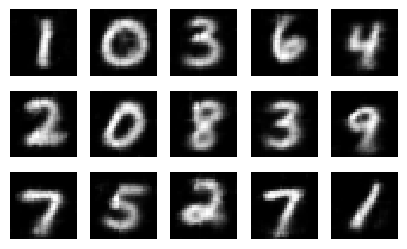

In [ ]:
# save outputs as images
# decode prototype vectors
prototype_imgs = model.decoder(prototype_distances.reshape((-1,10,2,2))).detach().cpu()
# visualize the prototype images
n_cols = 5
n_rows = n_prototypes // n_cols + 1 if n_prototypes % n_cols != 0 else n_prototypes // n_cols
g, b = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
for i in range(n_rows):
    for j in range(n_cols):
        if i*n_cols + j < n_prototypes:
            b[i][j].imshow(prototype_imgs[i*n_cols + j].reshape(input_height, input_width),
                                    cmap='gray',
                                    interpolation='none')
            b[i][j].axis('off')                   
#plt.savefig(os.path.join(img_folder, 'prototype_result-' + str(epoch+1) + '.png'),
#                    transparent=True, bbox_inches='tight', pad_inches=0)
plt.show()

plt.close()

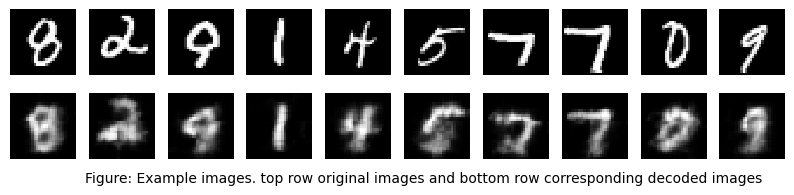

In [ ]:
# apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    break

examples_to_show = 10
        
encoded = model.encoder.forward(batch_x[:examples_to_show])
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu()


# compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
for i in range(examples_to_show):
    a[0][i].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
    a[0][i].axis('off')
    a[1][i].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
    a[1][i].axis('off')

f.text(.2,.005,'Figure: Example images. top row original images and bottom row corresponding decoded images')
#plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
#                    transparent=True,
#                    bbox_inches='tight',
#                    pad_inches=0)
plt.show()
plt.close()

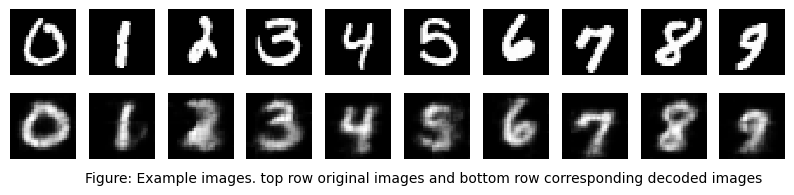

,0,1,2,3,4,5,6,7,8,9
0,14.135749,-9.585344,0.170952,-4.957730,-2.185811,-3.834075,4.561588,-7.901276,2.104727,0.445113
1,-3.737695,6.679622,0.221276,-0.665905,-1.151303,-2.406380,0.551393,-3.050456,-1.702445,-4.389057
2,0.212716,-0.643986,9.598364,-0.685067,-4.742047,-3.581737,1.140520,-3.445276,1.798503,-7.795106
3,-12.440902,-8.589395,-0.835640,15.754794,-1.600776,5.069705,-3.998803,-6.025884,3.678355,-4.114663
4,-8.470408,-1.926204,-6.173192,-8.462465,15.650002,-3.383022,-5.474608,6.955928,-6.966250,3.419357
5,-0.780401,-6.351414,-7.323987,2.605479,-5.897768,13.480057,1.368729,-7.623993,0.376449,1.512573
6,-2.467993,-6.364290,-3.035359,-11.389612,2.081457,4.322602,15.871693,-5.999253,0.393551,-0.668080
7,-5.599745,-1.612429,-0.318411,-0.439275,2.863652,-3.581117,-10.628551,12.374061,-5.725174,0.370648
8,0.110236,-5.632168,1.107058,0.056604,-4.566107,-3.224802,-2.278221,-12.076272,18.357594,-5.858363
9,0.176977,-5.065793,-5.889630,-0.124056,-0.403193,1.215267,-4.784594,-0.521120,-1.671107,9.533658


In [ ]:
import pandas as pd
# apply encoding and decoding over a small subset of the training set
batch_x = []
for batch in train_loader:
    batch_x = batch[0].to(device)
    batch_y = batch[1].to(device)
    break
    
pred_y = model.forward(batch_x)

pred_y_np = pred_y.detach().cpu().numpy() 
batch_y_np = batch_y.detach().cpu().numpy()
labels = []
data = []
idx = []
i = 0
j = 0
for l in batch_y_np:
    if(i==10):
        break
    if l==i:
        labels.append(l)
        data.append(pred_y_np[j])
        idx.append(j)
        i = i+1
    j = j + 1
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    
examples_to_show = 10
        
encoded = model.encoder.forward(batch_x)
decoded = model.decoder.forward(encoded)

decoded = decoded.detach().cpu()
imgs = batch_x.detach().cpu() 

# compare original images to their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))
j = 0
for i in idx:
    a[0][j].imshow(imgs[i].reshape(input_height, input_width),
                            cmap='gray',
                            interpolation='none')
    a[0][j].axis('off')
    a[1][j].imshow(decoded[i].reshape(input_height, input_width), 
                            cmap='gray',
                            interpolation='none')
    a[1][j].axis('off')
    j = j + 1
            
#plt.savefig(os.path.join(img_folder, 'decoding_result-' + str(epoch+1) + '.png'),
#                    transparent=True,
#                    bbox_inches='tight',
#                    pad_inches=0)
f.text(.2,.005,'Figure: Example images. top row original images and bottom row corresponding decoded images')
plt.show()
plt.close()
    
df = pd.DataFrame(data, labels, classes)
df.style.format(precision=2)
df.style.highlight_max(props='background-color:red;color:white;', axis=1)




# Examples of test

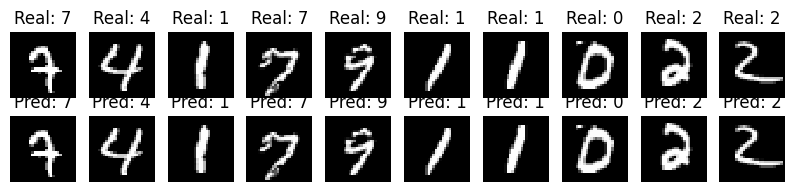

,Class 0,Class 1,Class 2,Class 3,Class 4,Class 5,Class 6,Class 7,Class 8,Class 9
Example 0,0.000000,0.000046,0.000702,0.000029,0.000054,0.000000,0.000000,0.999166,0.000000,0.000003
Example 1,0.000000,0.000000,0.000000,0.000000,0.999994,0.000000,0.000000,0.000006,0.000000,0.000000
Example 2,0.000045,0.997540,0.000125,0.000015,0.000004,0.000009,0.002100,0.000002,0.000159,0.000000
Example 3,0.000000,0.000002,0.000267,0.000375,0.000000,0.000001,0.000000,0.999354,0.000001,0.000000
Example 4,0.000009,0.000000,0.004109,0.030782,0.002114,0.006294,0.000003,0.072779,0.000104,0.883806
Example 5,0.000003,0.999466,0.000460,0.000000,0.000031,0.000000,0.000037,0.000001,0.000003,0.000000
Example 6,0.000001,0.999834,0.000149,0.000000,0.000001,0.000000,0.000013,0.000000,0.000002,0.000000
Example 7,0.999831,0.000023,0.000114,0.000000,0.000000,0.000000,0.000000,0.000018,0.000000,0.000013
Example 8,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Example 9,0.000006,0.000056,0.999696,0.000000,0.000004,0.000000,0.000000,0.000237,0.000000,0.000000


In [20]:
import torch
import matplotlib.pyplot as plt
import pandas as pd

# Obtener un batch de test
test_loader = get_test_loader(data_folder, batch_size, shuffle=True, num_workers=0, pin_memory=True)

# Obtener un batch del conjunto de test
batch_x, batch_y = next(iter(test_loader))
batch_x, batch_y = batch_x.to(device), batch_y.to(device)

# Hacer predicciones
with torch.no_grad():
    pred_y = model(batch_x)  # No usar forward() directamente

# Convertir a numpy para análisis
pred_y_np = pred_y.cpu().numpy()
batch_y_np = batch_y.cpu().numpy()

# Obtener probabilidades con softmax
probabilities = torch.nn.functional.softmax(pred_y, dim=1).cpu().numpy()

# Seleccionar ejemplos a mostrar
examples_to_show = 10
fig, axes = plt.subplots(2, examples_to_show, figsize=(examples_to_show, 2))

for i in range(examples_to_show):
    # Mostrar imagen original
    axes[0, i].imshow(batch_x[i].cpu().squeeze(), cmap="gray", interpolation="none")
    axes[0, i].axis("off")
    axes[0, i].set_title(f"Real: {batch_y_np[i]}")
    
    # Mostrar la clase predicha
    predicted_class = pred_y_np[i].argmax()
    axes[1, i].imshow(batch_x[i].cpu().squeeze(), cmap="gray", interpolation="none")
    axes[1, i].axis("off")
    axes[1, i].set_title(f" \nPred: {predicted_class}")

plt.show()

# Crear un DataFrame con probabilidades
df = pd.DataFrame(probabilities[:examples_to_show], 
                  index=[f"Example {i}" for i in range(examples_to_show)], 
                  columns=[f"Class {i}" for i in range(probabilities.shape[1])])


# Resaltar las predicciones más altas
df = df.style.highlight_max(axis=1, props="background-color: red; color: white;")
df


# Attacks

## Class Attack
https://github.com/Harry24k/adversarial-attacks-pytorch/tree/master/torchattacks

In [21]:
import time
from collections import OrderedDict

import torch
from torch.utils.data import DataLoader, TensorDataset


def wrapper_method(func):
    def wrapper_func(self, *args, **kwargs):
        result = func(self, *args, **kwargs)
        for atk in self.__dict__.get("_attacks").values():
            eval("atk." + func.__name__ + "(*args, **kwargs)")
        return result

    return wrapper_func


class Attack(object):
    r"""
    Base class for all attacks.

    .. note::
        It automatically set device to the device where given model is.
        It basically changes training mode to eval during attack process.
        To change this, please see `set_model_training_mode`.
    """

    def __init__(self, name, model):
        r"""
        Initializes internal attack state.

        Arguments:
            name (str): name of attack.
            model (torch.nn.Module): model to attack.
        """

        self.attack = name
        self._attacks = OrderedDict()

        self.set_model(model)
        try:
            self.device = next(model.parameters()).device
        except Exception:
            self.device = None
            print("Failed to set device automatically, please try set_device() manual.")

        # Controls attack mode.
        self.attack_mode = "default"
        self.supported_mode = ["default"]
        self.targeted = False
        self._target_map_function = None

        # Controls when normalization is used.
        self.normalization_used = None
        self._normalization_applied = None
        if self.model.__class__.__name__ == "RobModel":
            self._set_rmodel_normalization_used(model)

        # Controls model mode during attack.
        self._model_training = False
        self._batchnorm_training = False
        self._dropout_training = False

    def forward(self, inputs, labels=None, *args, **kwargs):
        r"""
        It defines the computation performed at every call.
        Should be overridden by all subclasses.
        """
        raise NotImplementedError

    @wrapper_method
    def set_model(self, model):
        self.model = model
        self.model_name = model.__class__.__name__

    def get_logits(self, inputs, labels=None, *args, **kwargs):
        if self._normalization_applied is False:
            inputs = self.normalize(inputs)
        logits = self.model(inputs)
        return logits

    @wrapper_method
    def _set_normalization_applied(self, flag):
        self._normalization_applied = flag

    @wrapper_method
    def set_device(self, device):
        self.device = device

    @wrapper_method
    def _set_rmodel_normalization_used(self, model):
        r"""
        Set attack normalization for MAIR [https://github.com/Harry24k/MAIR].

        """
        mean = getattr(model, "mean", None)
        std = getattr(model, "std", None)
        if (mean is not None) and (std is not None):
            if isinstance(mean, torch.Tensor):
                mean = mean.cpu().numpy()
            if isinstance(std, torch.Tensor):
                std = std.cpu().numpy()
            if (mean != 0).all() or (std != 1).all():
                self.set_normalization_used(mean, std)

    @wrapper_method
    def set_normalization_used(self, mean, std):
        self.normalization_used = {}
        n_channels = len(mean)
        mean = torch.tensor(mean).reshape(1, n_channels, 1, 1)
        std = torch.tensor(std).reshape(1, n_channels, 1, 1)
        self.normalization_used["mean"] = mean
        self.normalization_used["std"] = std
        self._set_normalization_applied(True)

    def normalize(self, inputs):
        mean = self.normalization_used["mean"].to(inputs.device)
        std = self.normalization_used["std"].to(inputs.device)
        return (inputs - mean) / std

    def inverse_normalize(self, inputs):
        mean = self.normalization_used["mean"].to(inputs.device)
        std = self.normalization_used["std"].to(inputs.device)
        return inputs * std + mean

    def get_mode(self):
        r"""
        Get attack mode.

        """
        return self.attack_mode

    @wrapper_method
    def set_mode_default(self):
        r"""
        Set attack mode as default mode.

        """
        self.attack_mode = "default"
        self.targeted = False
        print("Attack mode is changed to 'default.'")

    @wrapper_method
    def _set_mode_targeted(self, mode, quiet):
        if "targeted" not in self.supported_mode:
            raise ValueError("Targeted mode is not supported.")
        self.targeted = True
        self.attack_mode = mode
        if not quiet:
            print("Attack mode is changed to '%s'." % mode)

    @wrapper_method
    def set_mode_targeted_by_function(self, target_map_function, quiet=False):
        r"""
        Set attack mode as targeted.

        Arguments:
            target_map_function (function): Label mapping function.
                e.g. lambda inputs, labels:(labels+1)%10.
                None for using input labels as targeted labels. (Default)
            quiet (bool): Display information message or not. (Default: False)

        """
        self._set_mode_targeted("targeted(custom)", quiet)
        self._target_map_function = target_map_function

    @wrapper_method
    def set_mode_targeted_random(self, quiet=False):
        r"""
        Set attack mode as targeted with random labels.

        Arguments:
            quiet (bool): Display information message or not. (Default: False)

        """
        self._set_mode_targeted("targeted(random)", quiet)
        self._target_map_function = self.get_random_target_label

    @wrapper_method
    def set_mode_targeted_least_likely(self, kth_min=1, quiet=False):
        r"""
        Set attack mode as targeted with least likely labels.

        Arguments:
            kth_min (str): label with the k-th smallest probability used as target labels. (Default: 1)
            num_classses (str): number of classes. (Default: False)

        """
        self._set_mode_targeted("targeted(least-likely)", quiet)
        assert kth_min > 0
        self._kth_min = kth_min
        self._target_map_function = self.get_least_likely_label

    @wrapper_method
    def set_mode_targeted_by_label(self, quiet=False):
        r"""
        Set attack mode as targeted.

        Arguments:
            quiet (bool): Display information message or not. (Default: False)

        .. note::
            Use user-supplied labels as target labels.
        """
        self._set_mode_targeted("targeted(label)", quiet)
        self._target_map_function = "function is a string"

    @wrapper_method
    def set_model_training_mode(
        self, model_training=False, batchnorm_training=False, dropout_training=False
    ):
        r"""
        Set training mode during attack process.

        Arguments:
            model_training (bool): True for using training mode for the entire model during attack process.
            batchnorm_training (bool): True for using training mode for batchnorms during attack process.
            dropout_training (bool): True for using training mode for dropouts during attack process.

        .. note::
            For RNN-based models, we cannot calculate gradients with eval mode.
            Thus, it should be changed to the training mode during the attack.
        """
        self._model_training = model_training
        self._batchnorm_training = batchnorm_training
        self._dropout_training = dropout_training

    @wrapper_method
    def _change_model_mode(self, given_training):
        if self._model_training:
            self.model.train()
            for _, m in self.model.named_modules():
                if not self._batchnorm_training:
                    if "BatchNorm" in m.__class__.__name__:
                        m = m.eval()
                if not self._dropout_training:
                    if "Dropout" in m.__class__.__name__:
                        m = m.eval()
        else:
            self.model.eval()

    @wrapper_method
    def _recover_model_mode(self, given_training):
        if given_training:
            self.model.train()

    def save(
        self,
        data_loader,
        save_path=None,
        verbose=True,
        return_verbose=False,
        save_predictions=False,
        save_clean_inputs=False,
        save_type="float",
    ):
        r"""
        Save adversarial inputs as torch.tensor from given torch.utils.data.DataLoader.

        Arguments:
            save_path (str): save_path.
            data_loader (torch.utils.data.DataLoader): data loader.
            verbose (bool): True for displaying detailed information. (Default: True)
            return_verbose (bool): True for returning detailed information. (Default: False)
            save_predictions (bool): True for saving predicted labels (Default: False)
            save_clean_inputs (bool): True for saving clean inputs (Default: False)

        """
        if save_path is not None:
            adv_input_list = []
            label_list = []
            if save_predictions:
                pred_list = []
            if save_clean_inputs:
                input_list = []

        correct = 0
        total = 0
        l2_distance = []

        total_batch = len(data_loader)
        given_training = self.model.training

        for step, (inputs, labels) in enumerate(data_loader):
            start = time.time()
            adv_inputs = self.__call__(inputs, labels)
            batch_size = len(inputs)

            if verbose or return_verbose:
                with torch.no_grad():
                    outputs = self.get_output_with_eval_nograd(adv_inputs)

                    # Calculate robust accuracy
                    _, pred = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    right_idx = pred == labels.to(self.device)
                    correct += right_idx.sum()
                    rob_acc = 100 * float(correct) / total

                    # Calculate l2 distance
                    delta = (adv_inputs - inputs.to(self.device)).view(
                        batch_size, -1
                    )  # nopep8
                    l2_distance.append(
                        torch.norm(delta[~right_idx], p=2, dim=1)
                    )  # nopep8
                    l2 = torch.cat(l2_distance).mean().item()

                    # Calculate time computation
                    progress = (step + 1) / total_batch * 100
                    end = time.time()
                    elapsed_time = end - start

                    if verbose:
                        self._save_print(
                            progress, rob_acc, l2, elapsed_time, end="\r"
                        )  # nopep8

            if save_path is not None:
                adv_input_list.append(adv_inputs.detach().cpu())
                label_list.append(labels.detach().cpu())

                adv_input_list_cat = torch.cat(adv_input_list, 0)
                label_list_cat = torch.cat(label_list, 0)

                save_dict = {
                    "adv_inputs": adv_input_list_cat,
                    "labels": label_list_cat,
                }  # nopep8

                if save_predictions:
                    pred_list.append(pred.detach().cpu())
                    pred_list_cat = torch.cat(pred_list, 0)
                    save_dict["preds"] = pred_list_cat

                if save_clean_inputs:
                    input_list.append(inputs.detach().cpu())
                    input_list_cat = torch.cat(input_list, 0)
                    save_dict["clean_inputs"] = input_list_cat

                if self.normalization_used is not None:
                    save_dict["adv_inputs"] = self.inverse_normalize(
                        save_dict["adv_inputs"]
                    )  # nopep8
                    if save_clean_inputs:
                        save_dict["clean_inputs"] = self.inverse_normalize(
                            save_dict["clean_inputs"]
                        )  # nopep8

                if save_type == "int":
                    save_dict["adv_inputs"] = self.to_type(
                        save_dict["adv_inputs"], "int"
                    )  # nopep8
                    if save_clean_inputs:
                        save_dict["clean_inputs"] = self.to_type(
                            save_dict["clean_inputs"], "int"
                        )  # nopep8

                save_dict["save_type"] = save_type
                torch.save(save_dict, save_path)

        # To avoid erasing the printed information.
        if verbose:
            self._save_print(progress, rob_acc, l2, elapsed_time, end="\n")

        if given_training:
            self.model.train()

        if return_verbose:
            return rob_acc, l2, elapsed_time

    @staticmethod
    def to_type(inputs, type):
        r"""
        Return inputs as int if float is given.
        """
        if type == "int":
            if isinstance(inputs, torch.FloatTensor) or isinstance(
                inputs, torch.cuda.FloatTensor
            ):
                return (inputs * 255).type(torch.uint8)
        elif type == "float":
            if isinstance(inputs, torch.ByteTensor) or isinstance(
                inputs, torch.cuda.ByteTensor
            ):
                return inputs.float() / 255
        else:
            raise ValueError(type + " is not a valid type. [Options: float, int]")
        return inputs

    @staticmethod
    def _save_print(progress, rob_acc, l2, elapsed_time, end):
        print(
            "- Save progress: %2.2f %% / Robust accuracy: %2.2f %% / L2: %1.5f (%2.3f it/s) \t"
            % (progress, rob_acc, l2, elapsed_time),
            end=end,
        )

    @staticmethod
    def load(
        load_path,
        batch_size=128,
        shuffle=False,
        normalize=None,
        load_predictions=False,
        load_clean_inputs=False,
    ):
        save_dict = torch.load(load_path)
        keys = ["adv_inputs", "labels"]

        if load_predictions:
            keys.append("preds")
        if load_clean_inputs:
            keys.append("clean_inputs")

        if save_dict["save_type"] == "int":
            save_dict["adv_inputs"] = save_dict["adv_inputs"].float() / 255
            if load_clean_inputs:
                save_dict["clean_inputs"] = (
                    save_dict["clean_inputs"].float() / 255
                )  # nopep8

        if normalize is not None:
            n_channels = len(normalize["mean"])
            mean = torch.tensor(normalize["mean"]).reshape(1, n_channels, 1, 1)
            std = torch.tensor(normalize["std"]).reshape(1, n_channels, 1, 1)
            save_dict["adv_inputs"] = (save_dict["adv_inputs"] - mean) / std
            if load_clean_inputs:
                save_dict["clean_inputs"] = (
                    save_dict["clean_inputs"] - mean
                ) / std  # nopep8

        adv_data = TensorDataset(*[save_dict[key] for key in keys])
        adv_loader = DataLoader(adv_data, batch_size=batch_size, shuffle=shuffle)
        print(
            "Data is loaded in the following order: [%s]" % (", ".join(keys))
        )  # nopep8
        return adv_loader

    @torch.no_grad()
    def get_output_with_eval_nograd(self, inputs):
        given_training = self.model.training
        if given_training:
            self.model.eval()
        outputs = self.get_logits(inputs)
        if given_training:
            self.model.train()
        return outputs

    def get_target_label(self, inputs, labels=None):
        r"""
        Function for changing the attack mode.
        Return input labels.
        """
        if self._target_map_function is None:
            raise ValueError(
                "target_map_function is not initialized by set_mode_targeted."
            )
        if self.attack_mode == "targeted(label)":
            target_labels = labels
        else:
            target_labels = self._target_map_function(inputs, labels)
        return target_labels

    @torch.no_grad()
    def get_least_likely_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            _, t = torch.kthvalue(outputs[counter][l], self._kth_min)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    @torch.no_grad()
    def get_random_target_label(self, inputs, labels=None):
        outputs = self.get_output_with_eval_nograd(inputs)
        if labels is None:
            _, labels = torch.max(outputs, dim=1)
        n_classses = outputs.shape[-1]

        target_labels = torch.zeros_like(labels)
        for counter in range(labels.shape[0]):
            l = list(range(n_classses))
            l.remove(labels[counter])
            t = (len(l) * torch.rand([1])).long().to(self.device)
            target_labels[counter] = l[t]

        return target_labels.long().to(self.device)

    def __call__(self, inputs, labels=None, *args, **kwargs):
        given_training = self.model.training
        self._change_model_mode(given_training)

        if self._normalization_applied is True:
            inputs = self.inverse_normalize(inputs)
            self._set_normalization_applied(False)

            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            # adv_inputs = self.to_type(adv_inputs, self.return_type)

            adv_inputs = self.normalize(adv_inputs)
            self._set_normalization_applied(True)
        else:
            adv_inputs = self.forward(inputs, labels, *args, **kwargs)
            # adv_inputs = self.to_type(adv_inputs, self.return_type)

        self._recover_model_mode(given_training)

        return adv_inputs

    def __repr__(self):
        info = self.__dict__.copy()

        del_keys = ["model", "attack", "supported_mode"]

        for key in info.keys():
            if key[0] == "_":
                del_keys.append(key)

        for key in del_keys:
            del info[key]

        info["attack_mode"] = self.attack_mode
        info["normalization_used"] = (
            True if self.normalization_used is not None else False
        )

        return (
            self.attack
            + "("
            + ", ".join("{}={}".format(key, val) for key, val in info.items())
            + ")"
        )

    def __setattr__(self, name, value):
        object.__setattr__(self, name, value)

        attacks = self.__dict__.get("_attacks")

        # Get all items in iterable items.
        def get_all_values(items, stack=[]):
            if items not in stack:
                stack.append(items)
                if isinstance(items, list) or isinstance(items, dict):
                    if isinstance(items, dict):
                        items = list(items.keys()) + list(items.values())
                    for item in items:
                        yield from get_all_values(item, stack)
                else:
                    if isinstance(items, Attack):
                        yield items
            else:
                if isinstance(items, Attack):
                    yield items

        for num, value in enumerate(get_all_values(value)):
            attacks[name + "." + str(num)] = value
            for subname, subvalue in value.__dict__.get("_attacks").items():
                attacks[name + "." + subname] = subvalue

## FSGM Attack

https://arxiv.org/abs/1412.6572

Tipo de ataque: Ataque rápido de un solo paso.

Métrica de distancia: L_∞​ (modifica cada píxel con la misma magnitud máxima).

- Se calcula el gradiente de la pérdida con respecto a la entrada.
- Se usa solo una actualización en la dirección del gradiente para maximizar la pérdida.
- Rápido pero fácil de defender con adversarial training.

In [22]:
import torch
import torch.nn as nn

#from ..attack import Attack


class FGSM(Attack):
    r"""
    FGSM in the paper 'Explaining and harnessing adversarial examples'
    [https://arxiv.org/abs/1412.6572]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.FGSM(model, eps=8/255)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, eps=8 / 255):
        super().__init__("FGSM", model)
        self.eps = eps
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        images.requires_grad = True
        outputs = self.get_logits(images)

        # Calculate loss
        if self.targeted:
            cost = -loss(outputs, target_labels)
        else:
            cost = loss(outputs, labels)

        # Update adversarial images
        grad = torch.autograd.grad(
            cost, images, retain_graph=False, create_graph=False
        )[0]

        adv_images = images + self.eps * grad.sign()
        adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        return adv_images

In [23]:
pip install torchattacks

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [24]:
from torchattacks import FGSM  # Asegúrate de tener instalada la librería torchattacks

# Definir el ataque FGSM con el modelo y el valor de epsilon
attack = FGSM(model, eps=8/255)


In [25]:
# Obtener un lote de imágenes y etiquetas del conjunto de test
for batch in test_loader:
    batch_x = batch[0].to(device)  # Imágenes originales
    batch_y = batch[1].to(device)  # Etiquetas verdaderas
    break  # Solo usamos el primer batch para visualizar

# Generar imágenes adversarias
adv_images = attack(batch_x, batch_y)

# Obtener las predicciones antes y después del ataque
pred_orig = model(batch_x).argmax(dim=1)  # Predicción sin ataque
pred_adv = model(adv_images).argmax(dim=1)  # Predicción con ataque


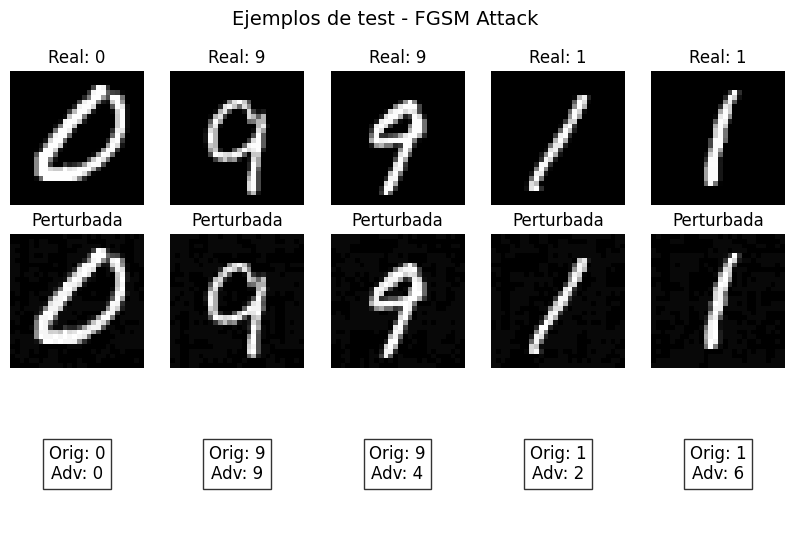

In [26]:
import matplotlib.pyplot as plt

examples_to_show = 5  # Número de imágenes a visualizar

fig, axes = plt.subplots(3, examples_to_show, figsize=(10, 6))
for i in range(examples_to_show):
    # Imagen original
    axes[0, i].imshow(batch_x[i].detach().cpu().numpy().squeeze(), cmap="gray")
    axes[0, i].set_title(f"Real: {batch_y[i].item()}")
    axes[0, i].axis("off")

    # Imagen perturbada
    axes[1, i].imshow(adv_images[i].detach().cpu().numpy().squeeze(), cmap="gray")
    axes[1, i].set_title(f"Perturbada")
    axes[1, i].axis("off")

    # Predicción antes y después del ataque
    axes[2, i].text(0.5, 0.5, f"Orig: {pred_orig[i].item()}\nAdv: {pred_adv[i].item()}", 
                    ha="center", va="center", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    axes[2, i].axis("off")

fig.suptitle("Ejemplos de test - FGSM Attack", fontsize=14)
plt.show()


In [27]:
import torch.nn.functional as F
import pandas as pd

probs_orig = F.softmax(model(batch_x), dim=1).detach().cpu().numpy()
probs_adv = F.softmax(model(adv_images), dim=1).detach().cpu().numpy()

df_orig = pd.DataFrame(probs_orig[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])
df_adv = pd.DataFrame(probs_adv[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])

print("Probabilidades originales:")
display(df_orig.style.format(precision=2).highlight_max(axis=1, props="background-color:blue;"))

print("Probabilidades con ataque FGSM:")
display(df_adv.style.format(precision=2).highlight_max(axis=1, props="background-color:red;color:white;"))


Probabilidades originales:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00
3,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Probabilidades con ataque FGSM:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.74,0.00,0.24,0.00,0.00,0.00,0.02,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.13,0.00,0.87
2,0.00,0.00,0.00,0.00,0.88,0.00,0.00,0.00,0.00,0.12
3,0.00,0.04,0.94,0.00,0.01,0.00,0.00,0.00,0.00,0.00
4,0.03,0.20,0.01,0.00,0.00,0.00,0.61,0.00,0.14,0.00


## PGD Attack

https://arxiv.org/abs/1706.06083

Tipo de ataque: Iterativo y más potente que FGSM.

- Se realiza FGSM en múltiples iteraciones, en pequeños pasos α.
- Se proyecta la imagen en el espacio permitido (manteniendo la perturbación dentro de ϵ).
- Es uno de los ataques más robustos y rompe muchas defensas de redes neuronales.



In [28]:
import torch
import torch.nn as nn


class PGD(Attack):
    r"""
    PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083]

    Distance Measure : Linf

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 8/255)
        alpha (float): step size. (Default: 2/255)
        steps (int): number of steps. (Default: 10)
        random_start (bool): using random initialization of delta. (Default: True)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.PGD(model, eps=8/255, alpha=1/255, steps=10, random_start=True)
        >>> adv_images = attack(images, labels)

    """

    def __init__(self, model, eps=8 / 255, alpha=2 / 255, steps=10, random_start=True):
        super().__init__("PGD", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()
        adv_images = images.clone().detach()

        if self.random_start:
            # Starting at a uniformly random point
            adv_images = adv_images + torch.empty_like(adv_images).uniform_(
                -self.eps, self.eps
            )
            adv_images = torch.clamp(adv_images, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]

            adv_images = adv_images.detach() + self.alpha * grad.sign()
            delta = torch.clamp(adv_images - images, min=-self.eps, max=self.eps)
            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

In [29]:
from torchattacks import PGD 

attack = PGD(model, eps=8/255)


In [30]:
# Obtener un lote de imágenes y etiquetas del conjunto de test
for batch in test_loader:
    batch_x = batch[0].to(device)  # Imágenes originales
    batch_y = batch[1].to(device)  # Etiquetas verdaderas
    break  # Solo usamos el primer batch para visualizar

# Generar imágenes adversarias
adv_images = attack(batch_x, batch_y)

# Obtener las predicciones antes y después del ataque
pred_orig = model(batch_x).argmax(dim=1)  # Predicción sin ataque
pred_adv = model(adv_images).argmax(dim=1)  # Predicción con ataque


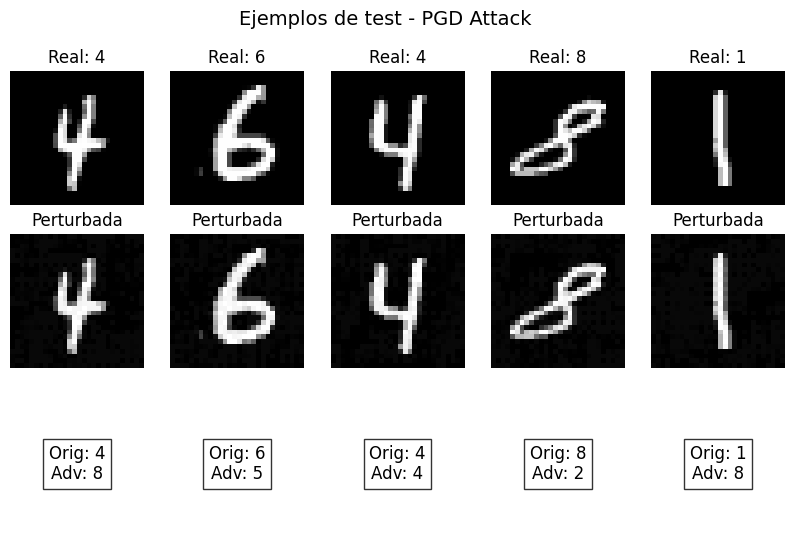

In [31]:
import matplotlib.pyplot as plt

examples_to_show = 5  # Número de imágenes a visualizar

fig, axes = plt.subplots(3, examples_to_show, figsize=(10, 6))
for i in range(examples_to_show):
    # Imagen original
    axes[0, i].imshow(batch_x[i].detach().cpu().numpy().squeeze(), cmap="gray")
    axes[0, i].set_title(f"Real: {batch_y[i].item()}")
    axes[0, i].axis("off")

    # Imagen perturbada
    axes[1, i].imshow(adv_images[i].detach().cpu().numpy().squeeze(), cmap="gray")
    axes[1, i].set_title(f"Perturbada")
    axes[1, i].axis("off")

    # Predicción antes y después del ataque
    axes[2, i].text(0.5, 0.5, f"Orig: {pred_orig[i].item()}\nAdv: {pred_adv[i].item()}", 
                    ha="center", va="center", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    axes[2, i].axis("off")

fig.suptitle("Ejemplos de test - PGD Attack", fontsize=14)
plt.show()


In [32]:
import torch.nn.functional as F
import pandas as pd

probs_orig = F.softmax(model(batch_x), dim=1).detach().cpu().numpy()
probs_adv = F.softmax(model(adv_images), dim=1).detach().cpu().numpy()

df_orig = pd.DataFrame(probs_orig[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])
df_adv = pd.DataFrame(probs_adv[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])

print("Probabilidades originales:")
display(df_orig.style.format(precision=2).highlight_max(axis=1, props="background-color:blue;"))

print("Probabilidades con ataque FGSM:")
display(df_adv.style.format(precision=2).highlight_max(axis=1, props="background-color:red;color:white;"))

Probabilidades originales:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00
4,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Probabilidades con ataque FGSM:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00,0.97,0.00
1,0.00,0.00,0.00,0.00,0.00,0.99,0.01,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.65,0.00,0.00,0.34,0.00,0.01
3,0.11,0.00,0.87,0.00,0.00,0.00,0.00,0.00,0.02,0.00
4,0.01,0.00,0.00,0.00,0.00,0.04,0.06,0.00,0.89,0.00


## PGDL2 Attack

https://arxiv.org/abs/1706.06083

PGD-L2 (Projected Gradient Descent en​ L2 )

- En vez de usar el signo del gradiente (como FGSM y PGD), lo normaliza en L2
- El ataque se mueve en la dirección óptima dentro del radio ϵ, pero en una norma L2.
- Menos perceptible visualmente que PGD en L∞​ , pero igual de efectivo.

In [33]:
import torch
import torch.nn as nn


class PGDL2(Attack):
    r"""
    PGD in the paper 'Towards Deep Learning Models Resistant to Adversarial Attacks'
    [https://arxiv.org/abs/1706.06083]

    Distance Measure : L2

    Arguments:
        model (nn.Module): model to attack.
        eps (float): maximum perturbation. (Default: 1.0)
        alpha (float): step size. (Default: 0.2)
        steps (int): number of steps. (Default: 10)
        random_start (bool): using random initialization of delta. (Default: True)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.PGDL2(model, eps=1.0, alpha=0.2, steps=10, random_start=True)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        eps=1.0,
        alpha=0.2,
        steps=10,
        random_start=True,
        eps_for_division=1e-10,
    ):
        super().__init__("PGDL2", model)
        self.eps = eps
        self.alpha = alpha
        self.steps = steps
        self.random_start = random_start
        self.eps_for_division = eps_for_division
        self.supported_mode = ["default", "targeted"]

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)

        if self.targeted:
            target_labels = self.get_target_label(images, labels)

        loss = nn.CrossEntropyLoss()

        adv_images = images.clone().detach()
        batch_size = len(images)

        if self.random_start:
            # Starting at a uniformly random point
            delta = torch.empty_like(adv_images).normal_()
            d_flat = delta.view(adv_images.size(0), -1)
            n = d_flat.norm(p=2, dim=1).view(adv_images.size(0), 1, 1, 1)
            r = torch.zeros_like(n).uniform_(0, 1)
            delta *= r / n * self.eps
            adv_images = torch.clamp(adv_images + delta, min=0, max=1).detach()

        for _ in range(self.steps):
            adv_images.requires_grad = True
            outputs = self.get_logits(adv_images)

            # Calculate loss
            if self.targeted:
                cost = -loss(outputs, target_labels)
            else:
                cost = loss(outputs, labels)

            # Update adversarial images
            grad = torch.autograd.grad(
                cost, adv_images, retain_graph=False, create_graph=False
            )[0]
            grad_norms = (
                torch.norm(grad.view(batch_size, -1), p=2, dim=1)
                + self.eps_for_division
            )  # nopep8
            grad = grad / grad_norms.view(batch_size, 1, 1, 1)
            adv_images = adv_images.detach() + self.alpha * grad

            delta = adv_images - images
            delta_norms = torch.norm(delta.view(batch_size, -1), p=2, dim=1)
            factor = self.eps / delta_norms
            factor = torch.min(factor, torch.ones_like(delta_norms))
            delta = delta * factor.view(-1, 1, 1, 1)

            adv_images = torch.clamp(images + delta, min=0, max=1).detach()

        return adv_images

In [34]:
from torchattacks import PGDL2 

attack = PGDL2(model, eps=8/255)

In [35]:
# Obtener un lote de imágenes y etiquetas del conjunto de test
for batch in test_loader:
    batch_x = batch[0].to(device)  # Imágenes originales
    batch_y = batch[1].to(device)  # Etiquetas verdaderas
    break  # Solo usamos el primer batch para visualizar

# Generar imágenes adversarias
adv_images = attack(batch_x, batch_y)

# Obtener las predicciones antes y después del ataque
pred_orig = model(batch_x).argmax(dim=1)  # Predicción sin ataque
pred_adv = model(adv_images).argmax(dim=1)  # Predicción con ataque

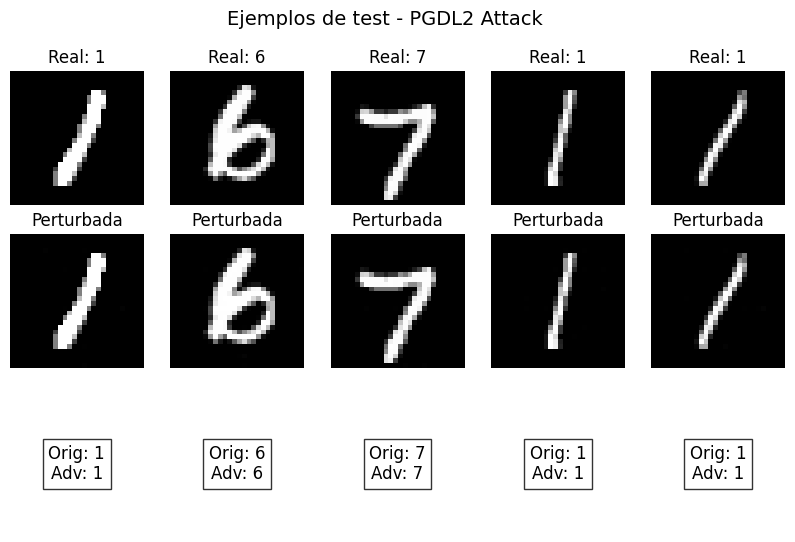

In [36]:
import matplotlib.pyplot as plt

examples_to_show = 5  # Número de imágenes a visualizar

fig, axes = plt.subplots(3, examples_to_show, figsize=(10, 6))
for i in range(examples_to_show):
    # Imagen original
    axes[0, i].imshow(batch_x[i].detach().cpu().numpy().squeeze(), cmap="gray")
    axes[0, i].set_title(f"Real: {batch_y[i].item()}")
    axes[0, i].axis("off")

    # Imagen perturbada
    axes[1, i].imshow(adv_images[i].detach().cpu().numpy().squeeze(), cmap="gray")
    axes[1, i].set_title(f"Perturbada")
    axes[1, i].axis("off")

    # Predicción antes y después del ataque
    axes[2, i].text(0.5, 0.5, f"Orig: {pred_orig[i].item()}\nAdv: {pred_adv[i].item()}", 
                    ha="center", va="center", fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
    axes[2, i].axis("off")

fig.suptitle("Ejemplos de test - PGDL2 Attack", fontsize=14)
plt.show()


In [37]:
import torch.nn.functional as F
import pandas as pd

probs_orig = F.softmax(model(batch_x), dim=1).detach().cpu().numpy()
probs_adv = F.softmax(model(adv_images), dim=1).detach().cpu().numpy()

df_orig = pd.DataFrame(probs_orig[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])
df_adv = pd.DataFrame(probs_adv[:examples_to_show], columns=[f"Clase {i}" for i in range(10)])

print("Probabilidades originales:")
display(df_orig.style.format(precision=2).highlight_max(axis=1, props="background-color:blue;"))

print("Probabilidades con ataque FGSM:")
display(df_adv.style.format(precision=2).highlight_max(axis=1, props="background-color:red;color:white;"))

Probabilidades originales:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Probabilidades con ataque FGSM:


,Clase 0,Clase 1,Clase 2,Clase 3,Clase 4,Clase 5,Clase 6,Clase 7,Clase 8,Clase 9
0,0.00,0.99,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
3,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


## Autoattack

In [38]:
import time



class AutoAttack(Attack):
    r"""
    AutoAttack in the paper 'Reliable evaluation of adversarial robustness with an ensemble of diverse parameter-free attacks'
    [https://arxiv.org/abs/2003.01690]
    [https://github.com/fra31/auto-attack]

    Distance Measure : Linf, L2

    Arguments:
        model (nn.Module): model to attack.
        norm (str) : Lp-norm to minimize. ['Linf', 'L2'] (Default: 'Linf')
        eps (float): maximum perturbation. (Default: 0.3)
        version (bool): version. ['standard', 'plus', 'rand'] (Default: 'standard')
        n_classes (int): number of classes. (Default: 10)
        seed (int): random seed for the starting point. (Default: 0)
        verbose (bool): print progress. (Default: False)

    Shape:
        - images: :math:`(N, C, H, W)` where `N = number of batches`, `C = number of channels`,        `H = height` and `W = width`. It must have a range [0, 1].
        - labels: :math:`(N)` where each value :math:`y_i` is :math:`0 \leq y_i \leq` `number of labels`.
        - output: :math:`(N, C, H, W)`.

    Examples::
        >>> attack = torchattacks.AutoAttack(model, norm='Linf', eps=8/255, version='standard', n_classes=10, seed=None, verbose=False)
        >>> adv_images = attack(images, labels)

    """

    def __init__(
        self,
        model,
        norm="Linf",
        eps=8 / 255,
        version="standard",
        n_classes=10,
        seed=None,
        verbose=False,
    ):
        super().__init__("AutoAttack", model)
        self.norm = norm
        self.eps = eps
        self.version = version
        self.n_classes = n_classes
        self.seed = seed
        self.verbose = verbose
        self.supported_mode = ["default"]

        if version == "standard":  # ['apgd-ce', 'apgd-t', 'fab-t', 'square']
            self._autoattack = MultiAttack(
                [
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="ce",
                        n_restarts=1,
                    ),
                    APGDT(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                    FAB(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        multi_targeted=True,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                    Square(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_queries=5000,
                        n_restarts=1,
                    ),
                ]
            )

        # ['apgd-ce', 'apgd-dlr', 'fab', 'square', 'apgd-t', 'fab-t']
        elif version == "plus":
            self._autoattack = MultiAttack(
                [
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="ce",
                        n_restarts=5,
                    ),
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="dlr",
                        n_restarts=5,
                    ),
                    FAB(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_classes=n_classes,
                        n_restarts=5,
                    ),
                    Square(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_queries=5000,
                        n_restarts=1,
                    ),
                    APGDT(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                    FAB(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        multi_targeted=True,
                        n_classes=n_classes,
                        n_restarts=1,
                    ),
                ]
            )

        elif version == "rand":  # ['apgd-ce', 'apgd-dlr']
            self._autoattack = MultiAttack(
                [
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="ce",
                        eot_iter=20,
                        n_restarts=1,
                    ),
                    APGD(
                        model,
                        eps=eps,
                        norm=norm,
                        seed=self.get_seed(),
                        verbose=verbose,
                        loss="dlr",
                        eot_iter=20,
                        n_restarts=1,
                    ),
                ]
            )

        else:
            raise ValueError("Not valid version. ['standard', 'plus', 'rand']")

    def forward(self, images, labels):
        r"""
        Overridden.
        """

        images = images.clone().detach().to(self.device)
        labels = labels.clone().detach().to(self.device)
        adv_images = self._autoattack(images, labels)

        return adv_images

    def get_seed(self):
        return time.time() if self.seed is None else self.seed

## atacks ..